<a href="https://colab.research.google.com/github/suka94/ADM_HW5/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework 5 - The Marvel Universe!**

##**1. Data**

We are going to build two different graphs:

1- First graph: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

2- Second graph: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.



In [ ]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import sample
import re
from itertools import combinations
from collections import Counter
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in the nodes data
nodes_df = pd.read_csv('/content/drive/MyDrive/ADM5/nodes.csv')
nodes_df.head()


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


In [ ]:
edges_df = pd.read_csv('/content/drive/MyDrive/ADM5/edges.csv')
edges_df.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


In [ ]:
hero_network_df = pd.read_csv('/content/drive/MyDrive/ADM5/hero-network.csv')
hero_network_df.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [ ]:
hero_network_df['hero1'] = hero_network_df['hero1'].str.strip().str.replace(' /', ' ')
hero_network_df['hero2'] = hero_network_df['hero2'].str.strip().str.replace(' /', ' ')
hero_network_df['hero1'] = hero_network_df['hero1'].str.strip().str.replace('/ ', ' ')
hero_network_df['hero2'] = hero_network_df['hero2'].str.strip().str.replace('/ ', ' ')
hero_network_df['hero1'] = hero_network_df['hero1'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')
hero_network_df['hero2'] = hero_network_df['hero2'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')


In [ ]:
# Remove self-loops from hero_network_df
hero_network_df = hero_network_df[hero_network_df['hero1'] != hero_network_df['hero2']]

hero_network_df.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [ ]:
collaboration_counts = defaultdict(int)
G1 = nx.MultiDiGraph()

for _, row in hero_network_df.iterrows():
    hero1, hero2 = row['hero1'], row['hero2']
    collaboration_counts[(hero1, hero2)] += 1
    # Add the two hero nodes to the graph if they don't already exist
    if hero1 not in G1:
        G1.add_node(hero1)
    if hero2 not in G1:
        G1.add_node(hero2)
    # Add an edge between the two hero nodes with a weight equal to the number of collaborations
    count = collaboration_counts[(hero1, hero2)]
    G1.add_edge(hero1, hero2, weight=count)

In [ ]:
G2 = nx.Graph()

for _, row in nodes_df.iterrows():
    G2.add_node(row['node'], type=row['type'])


In [ ]:
for _, row in edges_df.iterrows():
    G2.add_edge(row['hero'], row['comic'])


In [ ]:
nx.write_gml(G1, '/content/drive/MyDrive/ADM5/G1.gml')
nx.write_gml(G2, '/content/drive/MyDrive/ADM5/G2.gml')

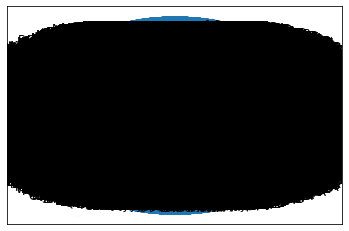

In [ ]:
# Load the graph from the GML file
G1 = nx.read_gml('/content/drive/MyDrive/ADM5/G1.gml')

# Use the spring layout to position the nodes
pos = nx.circular_layout(G1)

# Draw the nodes and edges
nx.draw_networkx(G1, pos)

# Show the plot
plt.show()

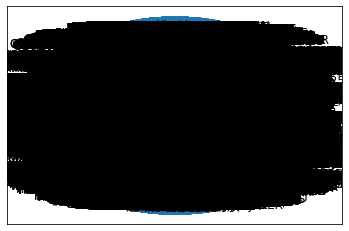

In [ ]:
# Load the graph from the GML file
G2 = nx.read_gml('/content/drive/MyDrive/ADM5/G2.gml')

# Use the spring layout to position the nodes
pos = nx.circular_layout(G2)

# Draw the nodes and edges
nx.draw_networkx(G2, pos)

# Show the plot
plt.show()

##**2. Backend Implementation**

In [ ]:
# # Solve version conflict between networkx and scipy when using pagerank
# import scipy
# import subprocess
# import sys

# if int(scipy.__version__[2]) < 8:
#   subprocess.check_call([sys.executable,"-m", "pip", "install", "scipy==1.8.0"])
#   print('IMPORTANT: RESTART RUNTIME BEFORE CONTINUING')
#   print(scipy.__version__)

Create the function that extracts the top $N$ heroes and build the corresponding subgraph.

In [ ]:
def get_top_N_subgraph(G, type_, N):

  if type_ == 1:
    # find number of comics per hero
    collaborations = defaultdict(int)
    for node in G.nodes():
      collaborations[node] = sum([G[node][neighbor]['count'] for neighbor in G.neighbors(node)])
    # sort them
    collaborations = dict(sorted(collaborations.items(), key = lambda x: x[1], reverse=True))
    # take top N
    nodes = [el[0] for el in list(collaborations.items())[:N]]


  if type_ == 2:
    # find number of comics per hero (aka degrees)
    degrees = sorted(G.degree, key=lambda x: x[1], reverse=True) 
    heroes_out = [el[0] for el in degrees if G.nodes[el[0]]['type'] == 'hero'][:N]
    comics_out = []
    for hero in heroes_out:
      comics_out = comics_out + list(G.neighbors(hero))
    nodes = list(set(heroes_out + comics_out))

  return G.subgraph(nodes)

## Functionality 1 - extract the graph's features

In [ ]:
def functionality_1(G, type_, N = None):
  
  if type_ == 1:
    if N:
      G = get_top_N_subgraph(G, type_, N)
    degrees = list(map(lambda x: x[1], G.degree))
    # number of nodes
    n_nodes = G.number_of_nodes()
    # collaborations
    pairs = list(combinations(list(G.nodes()), 2))
    collaborations = defaultdict(int)
    for el in pairs:
      try:
        collaborations[el] = G[el[0]][el[1]]['count']
      except:
        pass
    # density
    density = nx.density(G)
    # degree distribution
    degree_distro = Counter(degrees)
    # average degree
    average_degree = np.mean(np.array(degrees))
    # hubs
    _95_percentile = np.percentile(np.array(degrees), 95)
    hubs = [(key, value) for key, value in G.degree if value > _95_percentile]
    # sparse or dense
    if density > .5:
      sparse = False
    else:
      sparse = True

    out = {'n_nodes': n_nodes,
           'collaborations': collaborations,
           'density': density,
           'degree_distribution': degree_distro,
           'avg_degree': average_degree,
           'hubs': hubs,
           'sparse': sparse}

    
  if type_ == 2:
    if N:
      G = get_top_N_subgraph(G, type_, N)  
    heroes = [x for x,y in G.nodes(data=True) if y['type']=='hero']
    comics = [x for x,y in G.nodes(data=True) if y['type']=='comic']
    # number of nodes
    n_heroes = len(heroes)
    n_comics = len(comics)
    # number of heroes that have appeared in each comic
    heroes_in_comics = defaultdict(int)
    for el in comics:
      heroes_in_comics[el] = G.degree[el]
    # density
    density = len(G.edges()) / (n_heroes * n_comics)
    # degree distribution
    comics_degrees = [G.degree(el) for el in comics]
    degree_distro = Counter(comics_degrees)
    # average degree
    average_degree = np.mean(np.array(comics_degrees))
    # hubs
    _95_percentile = np.percentile(np.array(comics_degrees), 95)
    hubs = [(comic, G.degree(comic)) for comic in comics if G.degree(comic) > _95_percentile]
    # sparse or dense
    if density > .5:
      sparse = False
    else:
      sparse = True

    out = {'n_hero_nodes': n_heroes,
           'n_comics_nodes': n_comics,
           'heroes_in_comics': heroes_in_comics,
           'density': density,
           'comics_degree_distribution': degree_distro,
           'comics_avg_degree': average_degree,
           'comics_hubs': hubs,
           'sparse': sparse}

  return out


## Functionality 2 - Find top superheroes!

In [ ]:
def functionality_2(G, type_, node, metric, N = None):
  if N:
    G = get_top_N_subgraph(G, type_, N)
  
  if metric.lower() == 'betweeness':
    graph_betweness_centrality = nx.betweenness_centrality(G, normalized=True)
    node_betweeness_centrality = graph_betweness_centrality[node]
    return graph_betweness_centrality, node_betweeness_centrality

  if metric.lower() == 'pagerank':  
    graph_pagerank = nx.pagerank(G)
    node_pagerank = graph_pagerank[node]
    return graph_pagerank, node_pagerank

  if metric.lower() == 'closenesscentrality':
    graph_closeness = nx.closeness_centrality(G)
    node_closeness = graph_closeness[node]
    return graph_closeness, node_closeness
    
  if metric.lower() == 'degreecentrality':
    graph_degree = nx.degree(G)
    node_degree = graph_degree[node]
    return graph_degree, node_degree

**Degree:** how many neighbors a node have. A measure that it is not always much useful because indicates a local property, so gives us information only on a portion of the network. \\

**Closeness:** it measures how close, on average, a node is to all the nodes in the network, e.g. how much it is a good broadcaster. If the degree measures the local influence of a node closeness measures global influence. \\

**Betweness:** how often a node lies on shortest paths. It gives the "power" of a node, in the sense of how often do I have to visit it if I want to travel across the network. A node with very small degree can still have high betweeness, for example if it connects two clusters. \\

**PageRank:** an importance based on the neighbors of a node, and on the importance of such neighbors, and the importance of the neighbors of those neighbors and so on untill we reach all the network. It is relevant to remember that this measure is mathematically represented by a probability distribution so all the scores in a network must sum up to $1$, so the higher the importance of a node the less the importance of others. A node with high degree can still have a low PageRank score becuse it may be connected with not relevant node. Similarly a node with high betweeness  (indicating it connects different parts of a network) can have low PageRank as well because it may be far away from the most important nodes. \\



## Functionality 3 - Shortest ordered Route

For this functionality we use an algorithm that works in this way: we start finding the shortest path between $h_1$ and $h_2$ that doesn't touch the nodes $h_3 , ... , h_n$, then we find the shortest path between $h_2$ and $h_3$ that doesn't touch $h_4 , ... , h_n$ and so on. The concatenation of all the paths we obtain is the wanted walk.

In [ ]:
def functionality_3(G, h, h_1, h_n, N = None):
  if N:
    G = get_top_N_subgraph(G, 2, N)

  if nx.is_connected(G) == False:
    print('Graph not connected, impossible to find path')
    return
  
  h = [h_1] + h + [h_n]
  # nodes to ignore when computing the shortest path
  nodes_to_ignore = h
  shortest_walk = []
  for i in range(len(h) - 1): 
    start = h[i]
    end = h[i+1]
    nodes_to_ignore = h[i+2:]
    shortest_walk = shortest_walk[:-1] + nx.dijkstra_path(G, start, end, weight = lambda u, v, d: float('inf') if u in nodes_to_ignore or v in nodes_to_ignore else 1)
  return shortest_walk[1::2]  # returns only the comics in the walk

## Functionality 4 - Disconnecting Graphs

Here we use the Ford-Fulkerson algorithm to find the max flow in the network, then by using the well known max-flow min-cut theorem we obtain the min-cut.

In [ ]:
# define a BFS implementation suitable for the algorithm
def BFS(G, s, t, parent):
  visited = dict(zip(list(G.nodes()), [False]*G.number_of_nodes()))
  queue=[]
  queue.append(s)
  visited[s] = True
 
  while queue:
    u = queue.pop(0)
    for v in G.neighbors(u):
      if visited[v] == False and G[u][v]['weight'] > 0 :
        queue.append(v)
        visited[v] = True
        parent[v] = u
  return True if visited[t] else False

# define a DFS implementation suitable for the algorithm
def DFS(G,s,visited):
  visited[s] = True
  for node in G.neighbors(s):
    if G[s][node]['weight'] > 0 and not visited[node]:
      DFS(G, node, visited)

# Ford-Fulkerson algorithm
def functionality_4(G, type_, source, sink, N = None):
  if N:
    G = get_top_N_subgraph(G, type_, N)
  if G.number_of_nodes() > 1000:
    sys.setrecursionlimit(G.number_of_nodes() + 1)
  if type_ == 2:
    nx.set_edge_attributes(G, 1, 'weight')
  # make the graph directed by adding an edge with same attributes but in opposite direction for every existing edge
  G = G.to_directed()

# algorithm implementation
  parent = defaultdict(str)
  max_flow = 0
  while BFS(G, source, sink, parent):    
    path_flow = float("Inf")
    s = sink
    while(s != source):
      path_flow = min(path_flow, G[parent[s]][s]['weight'])
      s = parent[s]
    max_flow += path_flow
  

    v = sink
    while(v != source):
      u = parent[v]
      G[u][v]['weight'] -= path_flow
      G[v][u]['weight'] += path_flow
      v = parent[v]
# end of algorithm

# mark edges
  visited = dict(zip(list(G.nodes()), [False]*G.number_of_nodes()))
  DFS(G, s, visited)

# extract the edges belonging the min cut
  min_cut = []
  for edge in G.edges():
    i, j = edge
    if G[i][j]['weight'] == 0 and visited[i] and not visited[j]:   
      min_cut.append((i,j))
  
  return len(min_cut)   

## Functionality 5 - Extracting Communities

We use the Girvan-Newman algorithm proposed in the references.

In [ ]:
def edge_to_remove(graph):
  # pick the edge with the highest betweeness and remove it
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge


def functionality_5(G, N=None):
  if N:
    G = get_top_N_subgraph(G, 1, N)
  if nx.is_connected(G) == False:
    print('Graph not connected')
    return
  # unfreeze graph
  G = nx.Graph(G)

# main algorithm
  sg = nx.connected_components(G)
  sg_count = nx.number_connected_components(G)
  # continue to remove edges untill the graph disconnects
  while sg_count == 1:
    edge = edge_to_remove(G)
    G.remove_edge(*edge)
    sg = nx.connected_components(G)
    sg_count = nx.number_connected_components(G)

  return sg

##**3. Frontend Implementation**

reading the network from Pandas Dataframe to avoid problems with special characters

In [ ]:
hero1_hero2_frame = pd.read_csv('/content/drive/MyDrive/ADM5/hero-network.csv', sep=',')
hero_comic_frame = pd.read_csv('/content/drive/MyDrive/ADM5/edges.csv', sep=',')
node_type_frame = pd.read_csv('/content/drive/MyDrive/ADM5/nodes.csv', sep=',')

In [ ]:
hero_comic_frame

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


creating the three graphs

In [ ]:
hero1_hero2 = nx.from_pandas_edgelist(hero1_hero2_frame, "hero1", "hero2")
hero_comic = nx.from_pandas_edgelist(hero_comic_frame, "hero", "comic")
node_type = nx.from_pandas_edgelist(node_type_frame, "node", "type")

#Visualization 1 - Visualize some features of the network

considering the network as undirected

In [ ]:
print(hero1_hero2)

Graph with 6426 nodes and 167219 edges


In [ ]:
visualization1 = pd.DataFrame(columns = ['number_of_nodes', 'density', 'avg_degree_centrality', 'sparse_or_dense'])

In [ ]:
visualization1.loc['type_of_graph: hero1-hero2', 'number_of_nodes'] = nx.number_of_nodes(hero1_hero2)
visualization1.loc['type_of_graph: hero1-hero2', 'density'] = nx.density(hero1_hero2)
visualization1.loc['type_of_graph: hero1-hero2', 'avg_degree_centrality'] = round(sum([degree for (_, degree) in hero1_hero2.degree()]) / nx.number_of_nodes(hero1_hero2), 2)
visualization1.loc['type_of_graph: hero1-hero2', 'sparse_or_dense'] = np.where(nx.density(hero1_hero2) > 0.5, 'dense', 'sparse')

visualization1.loc['type_of_graph: hero-comic', 'number_of_nodes'] = nx.number_of_nodes(hero_comic)
visualization1.loc['type_of_graph: hero-comic', 'density'] = nx.density(hero_comic)
visualization1.loc['type_of_graph: hero-comic', 'avg_degree_centrality'] = round(sum([degree for (_, degree) in hero_comic.degree()]) / nx.number_of_nodes(hero_comic), 2)
visualization1.loc['type_of_graph: hero-comic', 'sparse_or_dense'] = np.where(nx.density(hero_comic) > 0.5, 'dense', 'sparse')

visualization1.loc['type_of_graph: node-type', 'number_of_nodes'] = nx.number_of_nodes(node_type)
visualization1.loc['type_of_graph: node-type', 'density'] = nx.density(node_type)
visualization1.loc['type_of_graph: node-type', 'avg_degree_centrality'] = round(sum([degree for (_, degree) in node_type.degree()]) / nx.number_of_nodes(node_type), 2)
visualization1.loc['type_of_graph: node-type', 'sparse_or_dense'] = np.where(nx.density(node_type) > 0.5, 'dense', 'sparse')

In [ ]:
visualization1

,number_of_nodes,density,avg_degree_centrality,sparse_or_dense
type_of_graph: hero1-hero2,6426,0.0081,52.04,sparse
type_of_graph: hero-comic,19090,0.000527,10.07,sparse
type_of_graph: node-type,19092,0.000105,2.0,sparse


# A table that lists the network's hubs


In [ ]:
avg_degree_centrality = visualization1.iloc[0,2]

degrees_each_hero = {hero:degree for (hero, degree) in hero1_hero2.degree()}

hubs = {hero:degree for (hero, degree) in degrees_each_hero.items() if degree > avg_degree_centrality}
hubs = {k: v for k, v in sorted(hubs.items(), key=lambda item: item[1], reverse=True)}

print('Lenght of hubs'' list:', len(hubs), '\n')
hubs = list(hubs.items())
print('List first 10 heros (hubs):')
print(*hubs[:10], sep='\n')

# print(sorted_hubs)

Lenght of hubs list: 1444 

List first 10 heros (hubs):
('CAPTAIN AMERICA', 1908)
('SPIDER-MAN/PETER PAR', 1737)
('IRON MAN/TONY STARK ', 1522)
('THING/BENJAMIN J. GR', 1416)
('MR. FANTASTIC/REED R', 1379)
('WOLVERINE/LOGAN ', 1371)
('HUMAN TORCH/JOHNNY S', 1361)
('SCARLET WITCH/WANDA ', 1325)
('THOR/DR. DONALD BLAK', 1289)
('BEAST/HENRY &HANK& P', 1267)


# A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)


In [ ]:
collaborations = hero_comic_frame.groupby('hero')['comic'].size()
collaborations = (collaborations.sort_values(ascending=False)).to_frame()
collaborations.reset_index(inplace=True)

collaborations.rename(columns={collaborations.columns[1]: 'number_of_collaboration'}, inplace=True)

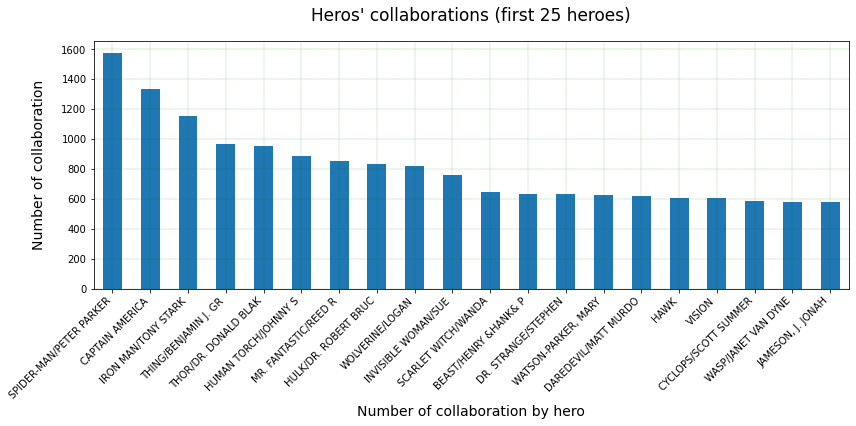

In [ ]:
# showing the first 25 heros for visualization reason

plt.rcParams['figure.figsize'] = [12, 6]

ax = collaborations.iloc[:20,:].plot(y="number_of_collaboration", x="hero", kind="bar")

plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xlabel("Number of collaboration by hero", fontsize= 14)
plt.ylabel("Number of collaboration", fontsize=14, labelpad=15)
plt.title("Heros' collaborations (first 25 heroes)", fontsize= 17, pad =20)
plt.tight_layout(pad=1)
plt.legend('', frameon=False)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)

plt.show()

# A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

In [ ]:
hero_per_comic = hero_comic_frame.groupby('comic')['hero'].size()
hero_per_comic = (hero_per_comic.sort_values(ascending=False)).to_frame()
hero_per_comic.reset_index(inplace=True)
hero_per_comic.rename(columns={hero_per_comic.columns[1]: 'number_of_heros'}, inplace=True)

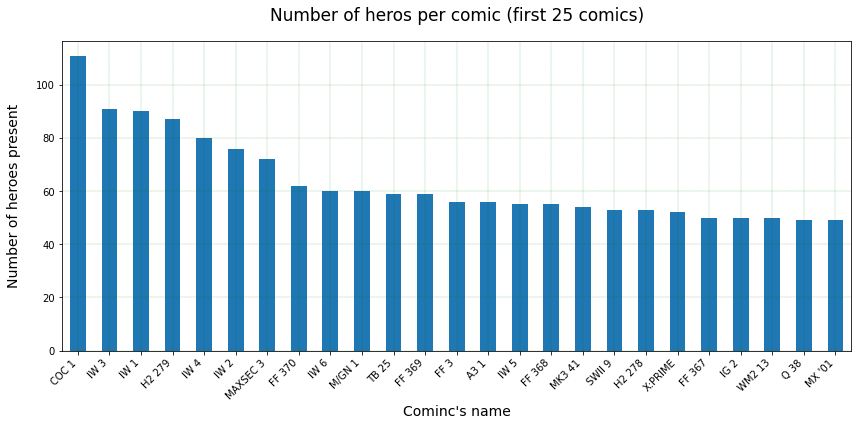

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]

ax = hero_per_comic.iloc[:25,:].plot( y = "number_of_heros", x = "comic", kind = "bar")

plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xlabel("Cominc's name", fontsize= 14)
plt.ylabel("Number of heroes present", fontsize=14, labelpad=15)
plt.title("Number of heros per comic (first 25 comics)", fontsize= 17, pad =20)
plt.tight_layout(pad=1)
plt.legend('', frameon=False)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)

plt.show()

# A plot depicting the degree distribution of the network (first kind of graph)

In [ ]:
degree_sequence = sorted([d for n, d in hero1_hero2.degree()], reverse=True)

In [ ]:
degree_sequence = pd.DataFrame(degree_sequence).astype(str)
degree_sequence.rename(columns={degree_sequence.columns[0]: 'degree'}, inplace=True)

In [ ]:
degree_sequence_grouped = degree_sequence.groupby('degree').size()

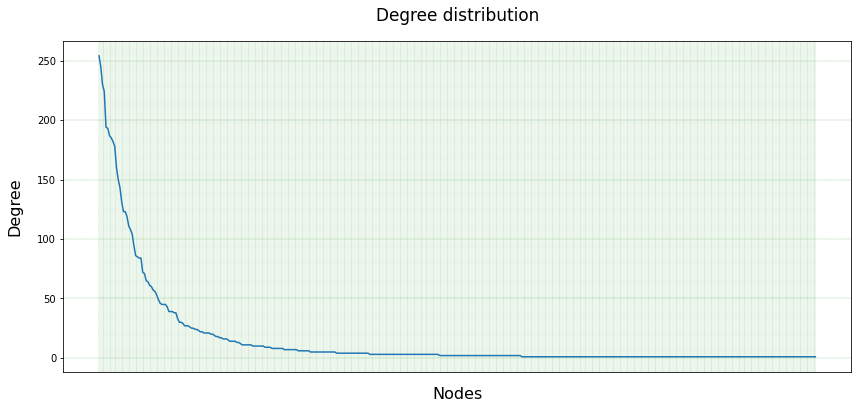

In [ ]:
plt.close()
plt.plot(degree_sequence_grouped.sort_values(ascending=False))

plt.ylabel("Degree", fontsize=16, labelpad=15)
plt.xlabel("Nodes", fontsize=16, labelpad=15)
plt.title("Degree distribution", fontsize= 17, pad =20)
plt.tight_layout(pad=1)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
plt.tick_params(labelbottom = False, bottom = False)

plt.show()

# Visualization 2 - Visualize centrality measure

In [ ]:
visualization2 = pd.DataFrame(columns = ['degree_centrality', 'eigenvector_centrality', 
                                         'closeness_centrality', 'betweenness_centrality'])
# creating dictionaries for all possible nodes
# created also for computational reason
eigen_centrality = nx.eigenvector_centrality_numpy(hero1_hero2)
closeness_centrality = nx.closeness_centrality(hero1_hero2)
betweenness_centrality = nx.betweenness_centrality(hero1_hero2)
page_rank = nx.pagerank(hero1_hero2)

## Example of node you can chose

In [ ]:
print('Samples from first kind of network:', *sample(list(hero1_hero2.nodes), 8), sep="\n")

# copy and paste the node's name from the print output example
selected_node = 'LORD CHAOS'

Samples from first kind of network:
LEVIATHAN IV
GLEASON, KAREN
MORRELL, SABRINA
FAMINE | MUTANT X-VE
DMITRI
COFFIN, WARDEN JOHNS
HEADMISTRESS/
CHENEY, LILA


In [ ]:
visualization2.loc['average values of all nodes', 'degree_centrality'] = np.mean(list(nx.degree_centrality(hero1_hero2).values()))
visualization2.loc['average values of all nodes', 'eigenvector_centrality'] = np.mean(list(eigen_centrality.values()))
visualization2.loc['average values of all nodes', 'closeness_centrality'] = np.mean(list(closeness_centrality.values()))
visualization2.loc['average values of all nodes', 'betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))

In [ ]:
visualization2

,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
average values of all nodes,0.0081,0.006047,0.381307,0.000254


In [ ]:
visualization2_2 = pd.DataFrame(columns = ['degree', 'page_rank', 
                                           'closeness_centrality', 'betweenness_centrality'])

In [ ]:
visualization2_2.loc[f'chosen node: {selected_node}', 'degree'] = nx.degree(hero1_hero2, selected_node)
visualization2_2.loc[f'chosen node: {selected_node}', 'page_rank'] = page_rank[selected_node]
visualization2_2.loc[f'chosen node: {selected_node}', 'closeness_centrality'] = nx.closeness_centrality(hero1_hero2, u = selected_node)
visualization2_2.loc[f'chosen node: {selected_node}', 'betweenness_centrality'] = betweenness_centrality[selected_node]

In [ ]:
visualization2_2

,degree,page_rank,closeness_centrality,betweenness_centrality
chosen node: LORD CHAOS,135,0.000314,0.468165,0.000109


# Visualization 3 - Visualize the shortest-ordered route

In [ ]:
print('Possible start node:', *list(hero_comic_frame['hero'].sample(5)), sep='\n')
print('\nPossible end node:', *list(hero_comic_frame['hero'].sample(5)), sep='\n' )

# copy and paste the node's name from the print output example
start_node = '3-D MAN/CHARLES CHAN'
end_node = 'FIREBIRD/BONITA JUAR'

Possible start node:
THING DOPPELGANGER I
RINGO KID
PAGE, KAREN
ENRAKT
KALA

Possible end node:
BOUDREAUX, BELLA DON
TARR, BLACK JACK
NORRISS, SISTER BARB
ROBERTSON, JOE
LIZARD/DR. CURTIS CO


In [ ]:
path = nx.shortest_path(hero_comic, source = start_node, target = end_node)

path_edges = list(zip(path, path[2:]))
path_edges = path_edges[::2]

path_nodes = list(path[0::2])
edges = path[1::2]

labels = {path_edges[i]:edges[i] for i in range(len(path_edges))}

In [ ]:
to_plot = nx.Graph()
to_plot.add_edges_from(path_edges)
pos = nx.spring_layout(to_plot)

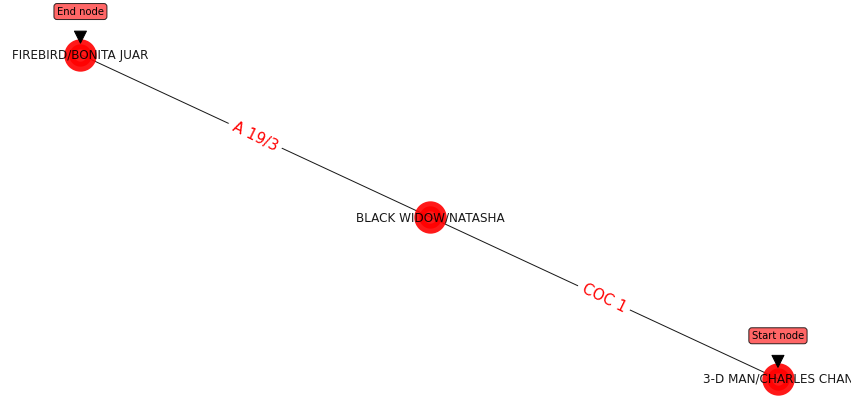

In [ ]:
plt.figure()
ax = plt.gca()

nx.draw(
    to_plot, pos, edge_color='black', width=1, linewidths=10,
    node_size=500, node_color='red', alpha=0.9,  font_size = 12,
    labels = {node: node for node in to_plot.nodes()})

nx.draw_networkx_edge_labels(to_plot, pos, edge_labels = labels, font_color='red', font_size=15)

ax.annotate("Start node", xy=pos.get(start_node), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

ax.annotate("End node", xy=pos.get(end_node), xytext=(0, 40), textcoords='offset points',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

plt.tight_layout(pad=1)

plt.show()

# Visualization 4 - Visualize the disconnected graph

In [ ]:
shrinked_graph = hero1_hero2_frame.iloc[:,:]
hero1_hero2 = nx.from_pandas_edgelist(shrinked_graph, "hero1", "hero2")

To make sure hero_A and hero_B are connected a control will be done.\
It's possible to choose to use a shrinked GiantComponent, where most of the heros are connected or a subgraph composed by the top 15 heroes.\
The best graph visualization is with 15 heroes.

In [ ]:
top15 = hubs[:15]
top15 = list(map(lambda x: x[0], top15))

In [ ]:
sub_graph = nx.subgraph(hero1_hero2, top15)

In [ ]:
giant_component = sorted(nx.connected_components(hero1_hero2), key=len, reverse=True) # True ---> giant component
giant_component = hero1_hero2.subgraph(giant_component[0])

In [ ]:
giant_component = nx.to_pandas_edgelist(giant_component)

In [ ]:
giant_component = giant_component.iloc[:30, :]
giant_component = nx.from_pandas_edgelist(giant_component, "source", "target")

## Do you want to use the GiantComponent or the Top15 subgraph?
## Please insert giantcomponent or top15

In [ ]:
selected_graph = input()

top15


In [ ]:
if selected_graph == 'top15':
    g = sub_graph.copy()
else:
    g = giant_component.copy()

In [ ]:
print('Possible start node:\n', g.nodes())

Possible start node:
 ['INVISIBLE WOMAN/SUE ', 'HUMAN TORCH/JOHNNY S', 'ANT-MAN/DR. HENRY J.', 'IRON MAN/TONY STARK ', 'SCARLET WITCH/WANDA ', 'THOR/DR. DONALD BLAK', 'MR. FANTASTIC/REED R', 'THING/BENJAMIN J. GR', 'HAWK', 'BEAST/HENRY &HANK& P', 'CAPTAIN AMERICA', 'SPIDER-MAN/PETER PAR', 'WASP/JANET VAN DYNE ', 'WOLVERINE/LOGAN ', 'VISION ']


In [ ]:
hero_A = 'WOLVERINE/LOGAN ' # related to subgraph A
hero_B = 'MR. FANTASTIC/REED R' # related to subgraph B

In [ ]:
if g.has_edge(hero_A, hero_B):
    print('Ok, heroes are connected!')
else:
    print('Please change heroA and/or heroB!')

Ok, heroes are connected!


In [ ]:
from networkx.algorithms.connectivity import minimum_st_edge_cut

minimum_cut_edge = dict(minimum_st_edge_cut(g, s = hero_A, t = hero_B))
print(minimum_cut_edge)

minimum_cut = len(nx.minimum_edge_cut(g, s = hero_A, t = hero_B))
print('\nThe minimum edge cut, for separating the original graph in two distinct subgraph is:', minimum_cut)

{'SCARLET WITCH/WANDA ': 'MR. FANTASTIC/REED R', 'HAWK': 'MR. FANTASTIC/REED R', 'BEAST/HENRY &HANK& P': 'MR. FANTASTIC/REED R', 'INVISIBLE WOMAN/SUE ': 'MR. FANTASTIC/REED R', 'SPIDER-MAN/PETER PAR': 'MR. FANTASTIC/REED R', 'WOLVERINE/LOGAN ': 'MR. FANTASTIC/REED R', 'CAPTAIN AMERICA': 'MR. FANTASTIC/REED R', 'WASP/JANET VAN DYNE ': 'MR. FANTASTIC/REED R', 'IRON MAN/TONY STARK ': 'MR. FANTASTIC/REED R', 'ANT-MAN/DR. HENRY J.': 'MR. FANTASTIC/REED R', 'HUMAN TORCH/JOHNNY S': 'MR. FANTASTIC/REED R', 'THING/BENJAMIN J. GR': 'MR. FANTASTIC/REED R', 'VISION ': 'MR. FANTASTIC/REED R', 'THOR/DR. DONALD BLAK': 'MR. FANTASTIC/REED R'}

The minimum edge cut, for separating the original graph in two distinct subgraph is: 14


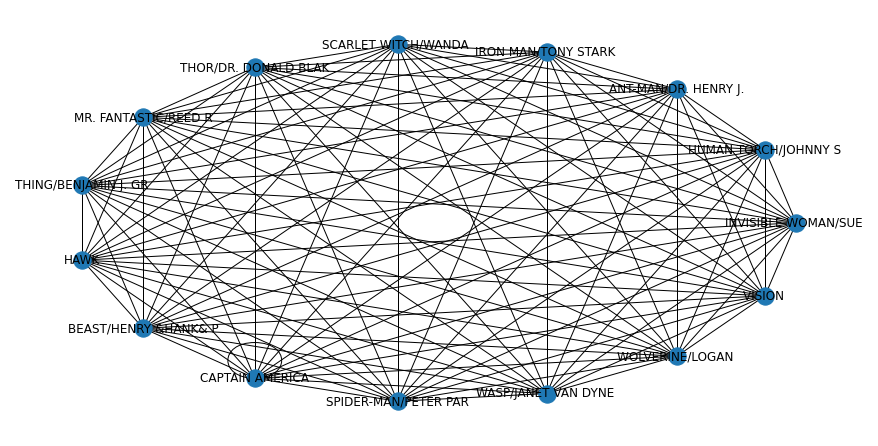

In [ ]:
nx.draw_circular(g, labels = {node: node for node in g.nodes()})

In [ ]:
minimum_cut_edge = [(k, v) for k, v in minimum_cut_edge.items()]

In [ ]:
disconnected_hero = g.copy()
disconnected_hero.remove_edges_from(minimum_cut_edge)

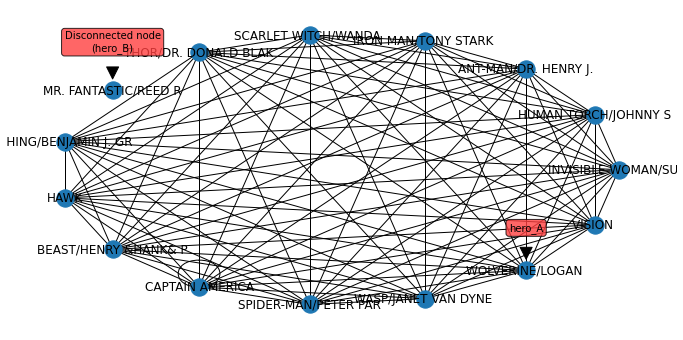

In [ ]:
plt.figure()
ax = plt.gca()

pos = nx.circular_layout(disconnected_hero)
nx.draw(disconnected_hero, pos, labels = {node: node for node in disconnected_hero.nodes()})

ax.annotate("Disconnected node\n(hero_B)", xy=pos.get(hero_B), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

ax.annotate("hero_A", xy=pos.get(hero_A), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

plt.show()

# Visualization 5 - Visualize the communities
## Girvan_newman method is implemented thanks to Networkx

## Please insert giantcomponent or top15

In [ ]:
selected_graph = input()

top15


In [ ]:
if selected_graph == 'top15':
    g = sub_graph.copy()
else:
    g = giant_component.copy()

In [ ]:
g=subgaph.copy()
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

In [ ]:
edge = edge_to_remove(g)
print('Number of edge(s) to remove to obtain communities:', int(len(edge) / 2)) 
# divided by 2 because 1 edge is equals to node-node that has lenght two.....2/2 = 1 edge removed

Number of edge(s) to remove to obtain communities: 1


In [ ]:
from networkx.algorithms import community

communities = nx.community.girvan_newman(g)
communities = tuple(c for c in next(communities))
communities

({'INVISIBLE WOMAN/SUE '},
 {'ANT-MAN/DR. HENRY J.',
  'BEAST/HENRY &HANK& P',
  'CAPTAIN AMERICA',
  'HAWK',
  'HUMAN TORCH/JOHNNY S',
  'IRON MAN/TONY STARK ',
  'MR. FANTASTIC/REED R',
  'SCARLET WITCH/WANDA ',
  'SPIDER-MAN/PETER PAR',
  'THING/BENJAMIN J. GR',
  'THOR/DR. DONALD BLAK',
  'VISION ',
  'WASP/JANET VAN DYNE ',
  'WOLVERINE/LOGAN '})

In [ ]:
for i in range(1, (len(communities)+1)):
    print(f'Community {i} formed by:', *list(communities[i-1]), sep="\n")
    print("\n")

Community 1 formed by:
INVISIBLE WOMAN/SUE 


Community 2 formed by:
HUMAN TORCH/JOHNNY S
ANT-MAN/DR. HENRY J.
SCARLET WITCH/WANDA 
THOR/DR. DONALD BLAK
IRON MAN/TONY STARK 
MR. FANTASTIC/REED R
THING/BENJAMIN J. GR
HAWK
BEAST/HENRY &HANK& P
CAPTAIN AMERICA
SPIDER-MAN/PETER PAR
WASP/JANET VAN DYNE 
WOLVERINE/LOGAN 
VISION 




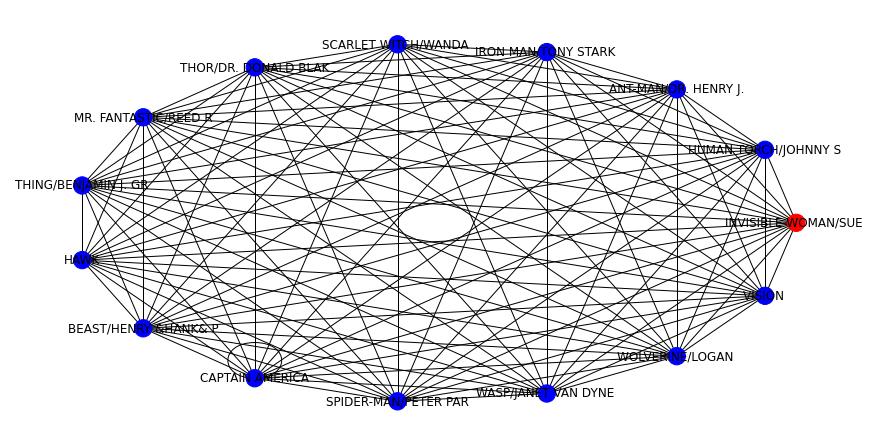

In [ ]:
communities = nx.community.girvan_newman(g)

node_groups = []

for i in next(communities):
    node_groups.append(list(i)) 
colors = []
for node in g:
    if node in node_groups[0]:
        colors.append('red')
    else:
        colors.append('blue')
nx.draw_circular(g, node_color = colors, labels = {node: node for node in g.nodes()})
plt.show()

Notes of visualization 5
### hero_1 = 'Captain America' and Hero_2 = 'Ironman' 

In [ ]:
hero_1 = 'CAPTAIN AMERICA'
hero_2 = 'IRON MAN/TONY STARK '

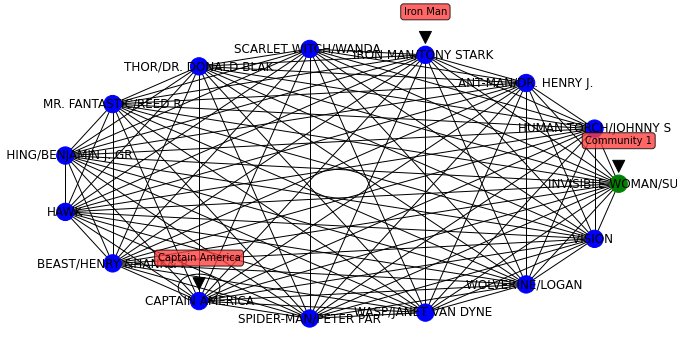

In [ ]:
communities = nx.community.girvan_newman(g)

pos = nx.circular_layout(g)

node_groups = []

for i in next(communities):
    node_groups.append(list(i)) 
colors = []
for node in g:
    if node in node_groups[0]:
        colors.append('green')
    else:
        colors.append('blue')

community1 = ''.join(node_groups[0])

ax = plt.gca()        

nx.draw_circular(g,  node_color = colors, labels = {node: node for node in g.nodes()})

ax.annotate("Captain America", xy=pos.get(hero_1), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

ax.annotate("Iron Man", xy=pos.get(hero_2), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')   

ax.annotate("Community 1", xy=pos.get(community1), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

plt.show()

In [ ]:
communities = nx.community.girvan_newman(g)
communities = tuple(c for c in next(communities))

for i in range(0, (len(communities))):
    if (hero_1 and hero_2) in list(communities[i]):
        print('Captain America and Iron Man belong to the same community!')
    elif i == len(communities):
        print('Captain America and Iron Man are not in same community!')

Captain America and Iron Man belong to the same community!


##**5. Bonus**

PageRank algorithm using the iterative MapReduce approach, based on the reference material provided:

In [ ]:
from collections import defaultdict

def pageRankIterativeMapReduce(pages, numIterations):
  for i in range(numIterations):
    pages = pageRankMapReduce(pages)
  return pages

def pageRankMapReduce(pages):
  # Map phase
  contributions = defaultdict(float)
  for page in pages:
    for q in page.outboundLinks:
      contributions[q] += page.rank / len(page.outboundLinks)
  # Reduce phase
  for page in pages:
    page.rank = (1 - DAMPING_FACTOR) / len(pages)
    for q in page.inboundLinks:
      page.rank += DAMPING_FACTOR * contributions[q] / len(q.outboundLinks)
  return pages


In this implementation, the pageRankMapReduce function represents a single iteration of the PageRank algorithm. The pageRankIterativeMapReduce function runs multiple iterations of the algorithm by calling pageRankMapReduce in a loop.

The PageRank algorithm is an iterative process that is used to rank the importance of pages on the internet. The algorithm assigns a score (called the "PageRank") to each page, based on the number and quality of links pointing to the page. Pages with a higher PageRank are considered more important and are more likely to appear at the top of search results.

The pageRankMapReduce function has two phases: the map phase and the reduce phase.

In the map phase, the function iterates over the pages and calculates a contribution to the rank of each page that the current page links to. The contribution is equal to the current page's rank divided by the number of outbound links it has. These contributions are stored in a defaultdict with the page as the key and the contribution as the value.

In the reduce phase, the function iterates over the pages again and updates each page's rank using the contributions stored in the defaultdict. The rank of each page is updated using the following formula:

page.rank = (1 - DAMPING_FACTOR) / len(pages) + DAMPING_FACTOR * sum(contributions[q] / len(q.outboundLinks) for q in page.inboundLinks)

This formula combines the damping factor (which determines the importance of the page's own rank versus the ranks of the pages it links to), the number of pages, and the contributions from the pages that link to the current page.

 DAMPING_FACTOR is a damping factor that is used to damp the influence of pages that have a lot of outbound links. It is a constant with a value between 0 and 1, typically set to 0.85. The idea behind the damping factor is to prevent pages with many outbound links from having too much influence on the PageRank of other pages.

Finally, the function returns the updated list of pages.

##**6. Algorithmic Question**

The idea is to create a **grid graph 3x3** with the library **NetworkX** and obtain all possible simple paths (i.e. paths with no repeated nodes) between pairs of nodes using  and consider the tuples indicating the nodes as coordinates. In this way we can take the tuple pairs in the individual paths and convert them into lists of strings with directions and then count the  complete matches of the input with the paths available.

In [ ]:
#import needed libraries
import networkx as nx
import matplotlib.pyplot as plt

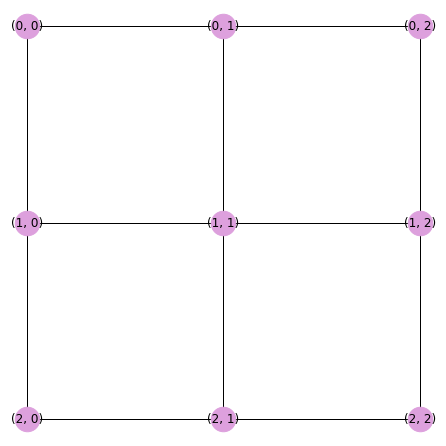

In [ ]:
#create a 2D grid graph
G = nx.grid_2d_graph(3,3)
#plot it
plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, pos=pos, 
        node_color='plum', 
        with_labels=True,
        node_size=600)

In [ ]:
G.nodes #check nodes name that could be used as coordinates

NodeView(((0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)))

In [ ]:
#create a dictionary to store the paths for each pair of nodes
paths = {}

#compute the simple paths between all pairs of nodes
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 != node2:  #skip pairs of the same node
            simple_paths = list(nx.all_simple_paths(G, node1, node2))
            #store the paths in the path dictionary using the tuple of nodes as key
            paths[(node1, node2)] = simple_paths


**The rationale used provides that:**


-If the first coordinate of the first and the second node are is equal and the second is greater in the case of the second node the movement will be to the right (R) or otherwise it will be to te left (L).


-If the second coordinate of the first and second node are equal while the first is greater in the second node the movement will be down (D) otherwise up (U).

In [ ]:
#create a new dictionary to store the paths in terms of directions
direction_paths = {}

#iterate over the keys and values in the paths dictionary
for (node1, node2), paths in paths.items():
    direction_paths_ = []
    #iterate over the paths
    for path in paths:
        directions = []
        #iterate over the nodes in the path
        for i in range(len(path) - 1):
            current_node = path[i]
            next_node = path[i + 1]
            #find directions associated to a couple of nodes in each path
            if current_node[0] == next_node[0] and next_node[1] > current_node[1]:
                direction = 'R' #right
            elif current_node[0] == next_node[0] and next_node[1] < current_node[1]:
                direction = 'L' #left
            elif current_node[1] == next_node[1] and next_node[0] > current_node[0]:
                direction = 'D' #down
            elif current_node[1] == next_node[1] and next_node[0] < current_node[0]:
                direction = 'U' #up
            directions.append(direction)
        direction_paths_.append(directions)
    #store the list of direction paths for this pair of nodes in the dictionary
    direction_paths[(node1, node2)] = direction_paths_ 

The created dictionary contains duplicates that cannot match with the possible inputs so it's necessary to remove adjacent duplicate letters

In [ ]:
#create a new dictionary to store the deduplicated paths
deduplicated_paths = {}

#iterate over the keys and values in the direction_paths dictionary
for (node1, node2), paths in direction_paths.items():
    deduplicated_paths_ = []
    #iterate over the paths
    for path in paths:
        deduplicated_path = [letter for i, letter in enumerate(path) if path[i] != path[i-1]]
        deduplicated_paths_.append(deduplicated_path)
    #store the list of deduplicated paths for this pair of nodes in the dictionary
    deduplicated_paths[(node1, node2)] = deduplicated_paths_


#### Function to count paths given as input the deduplicated dictionary and an input string

In [ ]:
#create a function that given an input returns the number of paths
def count_paths(dedup_paths, input_string):
    count = 0
    #iterate over the keys and values in the direction_paths dictionary
    for (node1, node2), paths in deduplicated_paths.items():
    #iterate over the paths
        for path in paths:
        #check if the input string is equal to the path tranformed from list to string
            if input_string =="".join(path):
            #add one to the counter
                count+=1
            
    return count


#### Try with different inputs

In [ ]:
input_string = input()
dedup_paths = deduplicated_paths
count_paths(dedup_paths, input_string)

DRU


15

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

R


9

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

LDRDRUL


0

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

ULDR


9

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

RDULULRD


0